# Libraries

In [1]:
import config

"""Generic"""
import warnings
from typing import Annotated
from typing import Optional
import os

import json

"""IPython"""
from IPython.display import Image


"""LangChain"""
import langchain_openai
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

"""LangGraph"""
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

from langgraph.prebuilt import InjectedState, create_react_agent, ToolNode
from langgraph_supervisor import create_supervisor

"""APIs"""
from fredapi import Fred
import yfinance as yf
fred = Fred(api_key=config.Config.FRED_API_KEY)

"""Data Analysis"""
import pandas as pd
import numpy as np
import quantstats as qs

"""Statistics"""
import statsmodels
from scipy import stats

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import grangercausalitytests

import matplotlib.pyplot as plt


# Scratchpad

## FRED

In [16]:
search_results = fred.search("LEI")
search_results = search_results[
    (search_results['frequency_short']=='M') | 
    (search_results['frequency_short']=='W') |
    (search_results['frequency_short']=='D')
]
search_results.sort_values('popularity', inplace=True)

result = search_results.head(1)
ticker = result['id'].values[0]
ticker_notes = result['notes'].values[0]
display(ticker_notes)

if ticker:
    ticker_df = fred.get_series(series_id=ticker)
    spy_df = yf.download('SPY', start=ticker_df.index[0], auto_adjust=True)['Close']
    spy_df = spy_df.resample('ME').last().iloc[:-2]
    ticker_df = ticker_df.resample('ME').last()
    combined_df = pd.concat([spy_df, ticker_df], axis=1)
    combined_df.columns = ['SP500', ticker]
    combined_df = combined_df.ffill().dropna()
    display(combined_df)

"The leading index for each state predicts the six-month growth rate of the state's coincident index. In addition to the coincident index, the models include other variables that lead the economy: state-level housing permits (1 to 4 units), state initial unemployment insurance claims, delivery times from the Institute for Supply Management (ISM) manufacturing survey, and the interest rate spread between the 10-year Treasury bond and the 3-month Treasury bill."

[*********************100%***********************]  1 of 1 completed


,SP500,NJSLIND
1993-01-31,24.380445,1.75
1993-02-28,24.640545,1.96
1993-03-31,25.192482,1.76
1993-04-30,24.547857,1.89
1993-05-31,25.209909,1.80
...,...,...
2025-01-31,598.246460,1.19
2025-02-28,590.651794,1.19
2025-03-31,557.741150,1.19
2025-04-30,552.905457,1.19


## Autocorrelation

In [4]:
# import statsmodels

# spy_df = yf.download('SPY', start='1981-01-01', auto_adjust=True)
# spy_df.columns = spy_df.columns.get_level_values(0)
# spy_df = spy_df['Close'].resample('W-FRI').last()
# # spy_df = spy_df[-300:]

# acf_vals = statsmodels.tsa.stattools.acf(spy_df, nlags=5, fft=True)

# # Format as list of dicts for LLM use
# acf_data = [{"lag": lag, "autocorrelation": round(acf_val, 6)} for lag, acf_val in enumerate(acf_vals) if lag != 0]

# # Optionally remove lag 0 (always 1.0, not useful for transformation)
# # acf_data = [item for item in acf_data if item["lag"] > 0]

# # Print nicely
# import json
# print(json.dumps(acf_data, indent=2))

## Load JSON

In [5]:
# spy_df1 = spy_df.copy()
# json_dict = json.loads(
#     '[\n    {\"tool\":\"sma\", \"args\":{\"window\":10}},\n    {\"tool\":\"zscore\", \"args\":{\"window\":7}},\n    {\"tool\":\"lag\", \"args\":{\"window\":3}}\n]'
# )

# for item in json_dict:
#     trm = item['tool']
#     window = item['args']['window']

#     if trm == 'sma':
#         spy_df1 = spy_df1.rolling(window).mean()
#     elif trm == 'log':
#         if len(spy_df1[spy_df1>0])==len(spy_df1):
#             spy_df1 = np.log(spy_df1)
#     elif trm == 'ema':
#         spy_df1 = spy_df1.ewm(window).mean()
#     elif trm == 'lag':
#         spy_df1 = spy_df1.shift(window)
#     elif trm == 'zscore':
#         mean = spy_df1.rolling(window).mean()
#         std = spy_df1.rolling(window).std()
#         zscore = (spy_df1 - mean)/std
#         spy_df1 = zscore

# spy_df1 = spy_df1.dropna()
# spy_df1.plot()
# plt.show()
# spy_df.plot()
# plt.show()

## Load Parquet

,SP500,WEI,signal_tfm
2008-03-31,95.510689,1.67,0.00
2008-04-30,100.062912,1.06,0.26
2008-05-31,101.575546,0.84,-0.61
2008-06-30,93.086266,1.01,-0.22
2008-07-31,92.249817,0.87,0.17
...,...,...,...
2025-03-31,557.741150,2.28,-0.36
2025-04-30,552.905457,2.31,-0.15
2025-05-31,587.652771,1.76,0.03
2025-06-30,587.652771,2.13,-0.55


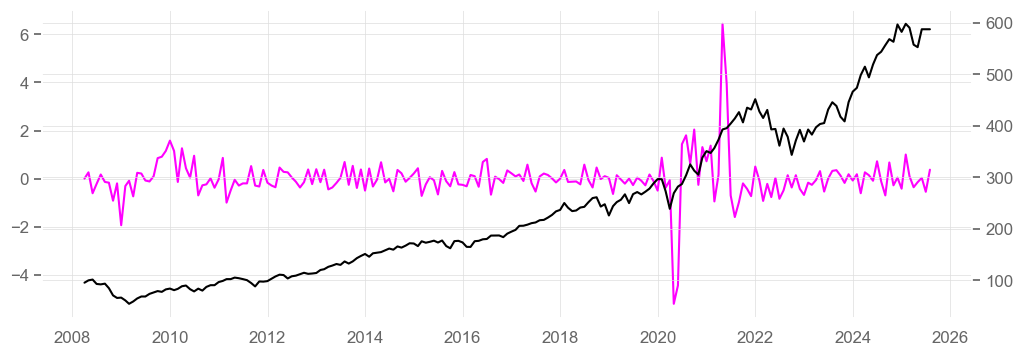

In [82]:
tmp_df = pd.read_parquet('agent_files/fred_df.parquet')
display(tmp_df)

if 'signal_tfm' in tmp_df.columns:
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(tmp_df['signal_tfm'], color='magenta')
    ax2 = ax.twinx()
    ax2.plot(tmp_df['SP500'], color='black')
    plt.show()

# Definitions

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    symbol: str
    fred_df_path: str
    frequency: str
    descriptive_stats: str
    transform_pipeline: list
    input: Optional[str]

model = langchain_openai.AzureChatOpenAI(
    deployment_name=config.Config.AZURE_OPENAI_DEPLOYMENT_NAME,
    model="gpt-4.1-nano",
    temperature=0,
    openai_api_version=config.Config.OPENAI_API_VERSION,
)

llm = init_chat_model(
    "azure_openai:gpt-4.1-nano",
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
)


# Tools

### Extract Symbol

In [127]:
def extract_symbol_from_message(state:dict) -> dict:
    fn_name = "extract_symbol_from_message"
    user_msg = state["messages"][-1].content
    prompt = f"Extract the FRED series ID from this message: \"{user_msg}\"\". Return only the symbol, nothing else."

    response = llm.invoke(prompt)
    symbol = response.content.strip().upper()

    tool_msg = f"[{fn_name}] Successfully extracted {symbol} from prompt:"
    tool_msg += "\n"
    tool_msg += f"{prompt}"

    return {
        **state,
        "messages":             
            [
                ToolMessage(
                    tool_call_id=fn_name, 
                    content=tool_msg
                )
            ],
        "symbol": symbol
    }

### Download Data

In [90]:
def download_data(state:State) -> dict:
    """Download data from FRED for the given symbol."""

    fn_name="download_data"
    global ticker_notes
    ticker = None
    symbol = state['symbol']

    search_results = fred.search(symbol)
    search_results = search_results[
        (search_results['frequency_short']=='M') | 
        (search_results['frequency_short']=='W') |
        (search_results['frequency_short']=='D')
    ]
    search_results.sort_values('popularity', inplace=True)

    result = search_results.head(1)
    ticker = result['id'].values[0]
    ticker_notes = result['notes'].values[0]
    file_path = 'agent_files/fred_df.parquet'

    if ticker:
        ticker_df = fred.get_series(series_id=ticker)
        spy_df = yf.download('SPY', start=ticker_df.index[0], auto_adjust=True)['Close']
        spy_df = spy_df.resample('ME').last().iloc[:-2]
        ticker_df = ticker_df.resample('ME').last()
        combined_df = pd.concat([spy_df, ticker_df], axis=1)
        combined_df.columns = ['SP500', ticker]
        combined_df = combined_df.ffill().dropna()
        combined_df.to_parquet(file_path)         

        return {   
            **state,         
            "frequency": "Monthly",
            "fred_df_path": "agent_files/fred_df.parquet",
            "messages": 
            state["messages"] + 
            [
                ToolMessage(
                    tool_call_id=fn_name,
                    content=f"[{fn_name}] Downloaded {symbol} and saved to parquet <{file_path}>."
                )
            ],
            "transform_pipeline": [],
            "input": END
        }
    
    return {
        **state,
        "frequency": None,
        "fred_df_path": None,
        "messages": state["messages"] + [f"Symbol '{symbol}' not found."],
        "transform_pipeline": [],
        "input": END
    }

@tool
def download_data1(state: State) -> dict:
    """Download data from FRED for the given symbol."""
    
    symbol = state['symbol']
    search_results = fred.search(symbol)
    search_results = search_results[
        (search_results['frequency_short']=='M') | (search_results['frequency_short']=='W')]
    search_results.sort_values('popularity', inplace=True)

    result = search_results.head(1)
    ticker = result['id'].values[0]
    frequency = result['frequency_short'].values[0]
    ticker_notes = result['notes'].values[0]

    if ticker:
        ticker_df = fred.get_series(series_id=ticker)
        spy_df = yf.download('SPY', start=ticker_df.index[0], auto_adjust=True)['Close']
        spy_df = spy_df.resample('ME').last().iloc[:-2]
        ticker_df = ticker_df.resample('ME').last()
        combined_df = pd.concat([spy_df, ticker_df], axis=1)
        combined_df.columns = ['SP500', ticker]
        combined_df = combined_df.ffill().dropna()
        combined_df.to_parquet('agent_files/fred_df.parquet')

        return {   
            **state,         
            "frequency": "Monthly",
            "fred_df_path": "agent_files/fred_df.parquet",
            "messages": state["messages"] + [f"Downloaded {symbol} and saved to parquet."],
            "transform_pipeline": [],
            "input": "Run describe_data tool"         
        }
    
    return {
        **state,
        "frequency": None,
        "fred_df_path": None,
        "messages": state["messages"] + [f"Symbol '{symbol}' not found."],
        "transform_pipeline": [],
        "input": "End"
    }


### Describe Data

In [97]:
def describe_data(state: State) -> dict:
    """Generate descriptive stats from dataframe"""

    fn_name = 'describe_data'
    df = pd.read_parquet(state['fred_df_path'])
    col_name = df.columns[-1]
    # num_obs = 300
    # x = df[col_name].iloc[-num_obs:]
    x = df[col_name]

    # Autocorrelation (ACF)
    acf_vals = statsmodels.tsa.stattools.acf(x, nlags=20, fft=True)
    acf_data = [
        {"lag": lag, "autocorrelation": round(acf_val, 6)} for lag, acf_val in enumerate(acf_vals) if lag != 0
    ]

    # Normality tests
    try:
        adf_pval = adfuller(x, autolag='AIC')[1]
    except:
        adf_pval = np.nan

    desc_stats = dict(
        num_negative=len(x[x<0]),
        mean=np.mean(x),
        median=np.median(x),
        std=np.std(x, ddof=1),
        skew=stats.skew(x),
        kurtosis=stats.kurtosis(x, fisher=False),
        acf=acf_data,
        adf_pval=adf_pval,
    )

    prompt = (
        f""" 
        Generate a concise summary with regards to data transformation based on the descriptive stats below
        {json.dumps(desc_stats)}
        If adf p-value < 0.01, dataset is stationary
        Include observation about num_negative

        IMPORTANT:
        Do not suggest box cox or log if there are negative values
        Do not provide any suggestions
        """
    )

    response = model.invoke(prompt)

    return {
        **state,
        "messages": 
            state["messages"] + 
            [
                AIMessage(f"[{fn_name}] {response.content}")
            ],
        "descriptive_stats": response.content
    }

### Suggest Transformations

In [119]:
def suggest_transformations(state:State):
    """Suggest from 1 to 3 transformations on the data based on the descriptive stats"""    
    global ticker_notes

    prompt=(f"""
    You are selecting from 1 to 3 data transformations based on the provided descriptive statistics.
            
    Summary of the dataset:
    {ticker_notes}

    Summary of the descriptive stats:
    {state['descriptive_stats']}
    
    NOTE:
    - If non-stationary, suggest diff or pct_change
    - DO NOT use pct_change if the dataset is already in percentage
    - DO NOT use diff or percentage change if adf_pval < 0.02
    - DO NOT suggest box_cox or log_transform if there are negative values
    - ALWAYS use lag as the last transformation

    Available tools and valid window values:
    - diff = [1,3,5,10])
    - pct_change = [1,3,5,10,20])        
    - sma = [1,3,5])
    - ema = [1,3,5])
    - log_transform = [0]
    - zscore = [50,100,150,200,250])
    - minmax_scale = [20,50,100])
    - rolling_std = [50,100,150,200,250])
    - lag = [1,2,3,5,10,20,50])

    You MUST follow these rules:
    - Only use tools from the list above
    - The key must be "tool", not "name"
    - The tool name must exactly match one of the tool names listed
    """
    )

    prompt += "Only return a json of this format: [{'tool': 'log_transform', 'args': {'window': 0}},{'tool': 'diff', 'args': {'window': 1}}]"
    prompt += "Remove the \n at the start of the response"

    response = model.invoke(prompt)
    return {
        **state,
        "messages": state["messages"] + [AIMessage(response.content)],
        "transform_pipeline": json.loads(response.content)
    }

### Implement Transformations

In [102]:
def implement_transformations(state:State) -> State:
    """Implement transformations from transform_pipeline in state dictionary"""

    fn_name = "implement_transformations"

    trm_lst = []
    if state['transform_pipeline'] is not None:
        json_dict = state['transform_pipeline']

        fred_df = pd.read_parquet(state['fred_df_path'])
        colname = 'signal_tfm'
        fred_df[colname] = fred_df[fred_df.columns[-1]]        

        for item in json_dict:
            trm = item['tool']            

            if trm == 'sma':
                fred_df[colname] = fred_df[colname].rolling(item['args']['window']).mean()
                trm_lst.append(trm)
            elif trm == 'log':
                if len(fred_df[colname][fred_df[colname]>0])==len(fred_df[colname]):
                    fred_df[colname] = np.log(fred_df[colname])
                    trm_lst.append(trm)
            elif trm == 'ema':
                fred_df[colname] = fred_df[colname].ewm(item['args']['window']).mean()
                trm_lst.append(trm)
            elif trm == 'lag':
                fred_df[colname] = fred_df[colname].shift(item['args']['window'])
                trm_lst.append(trm)
            elif trm == 'log_transform':                
                fred_df[colname] = np.log(fred_df[colname])
                trm_lst.append(trm)
            elif trm == 'zscore':
                mean = fred_df[colname].rolling(item['args']['window']).mean()
                std = fred_df[colname].rolling(item['args']['window']).std()
                zscore = (fred_df[colname] - mean)/std
                fred_df[colname] = zscore
                trm_lst.append(trm)
            elif trm == 'diff':
                fred_df[colname] = fred_df[colname].diff(item['args']['window'])
                trm_lst.append(trm)

        fred_df = fred_df.ffill()
        fred_df = fred_df.dropna()
        fred_df.to_parquet('agent_files/fred_df.parquet')

    return {
        **state,
        "messages": 
            state["messages"] + 
            [
                ToolMessage(
                    tool_call_id=fn_name,
                    content=f"[{fn_name}] {len(trm_lst)} transformations: {str(trm_lst)} have been executed"
                )
            ]
    }


## Generate Strategies

In [8]:
def calc_performance_metrics(
        df:pd.DataFrame, 
        colname:str, 
        num_periods:int
):
    avg_return = df[colname].mean()

    return {
        "annualised_returns": avg_return*num_periods,
        "annualised_volatility":qs.stats.volatility(df[colname], periods=num_periods),
        "sharpe_ratio":qs.stats.sharpe(df[colname], periods=num_periods),
        "sortino_ratio":qs.stats.sortino(df[colname], periods=num_periods),
        "max_drawdown":qs.stats.max_drawdown(df[colname]),
    }

### Z-score reversal

In [141]:
@tool
def zscore_reversal(state:State, buy_threshold:float, sell_threshold:float):
    """
    Perform a zscore-reversal strategy where 
    1. BUY: <= Z-score threshold
    2. SELL: >= Z-score threshold
    """

    strat_df = pd.read_parquet(state['fred_df_path'])
    
    if strat_df is not None:
        strat_df['signal'] = np.where(
            strat_df['signal_tfm'] <= buy_threshold, 1,
            np.where(strat_df['signal_tfm'] >= sell_threshold, -1, np.nan)
        )
        strat_df['signal'] = strat_df['signal'].ffill().bfill()
        strat_df['returns'] = strat_df['SP500'].pct_change()
        strat_df['strat_returns'] = strat_df['signal'].shift(1) * strat_df['returns']

        strat_df = strat_df.dropna()        

        return {
            **state,
            "performance_metrics": json.dumps(calc_performance_metrics(
                df=strat_df, 
                colname="strat_returns",
                num_periods=12
            ))
        }

    return {
        **state
    }

### SMA Cross-over

In [138]:
@tool
def sma_trend(state:State, slow_sma:int, fast_sma:int):
    """
    Perform a sma crossover strategy where 
    1. BUY: fast_sma > slow_sma
    2. SELL: fast_sma < slow_sma
    """

    strat_df = pd.read_parquet(state['fred_df_path'])
    buy_wt = 1
    sell_wt = -1
    
    if strat_df is not None:
        strat_df['fast_sma'] = strat_df['signal_tfm'].rolling(fast_sma).mean()
        strat_df['slow_sma'] = strat_df['signal_tfm'].rolling(slow_sma).mean()
        strat_df['signal'] = np.where(
            strat_df['fast_sma'] > strat_df['slow_sma'], buy_wt,
            np.where(strat_df['fast_sma'] < strat_df['slow_sma'], sell_wt, np.nan)
        )
        strat_df['signal'] = strat_df['signal'].ffill().bfill()
        strat_df['returns'] = strat_df['SP500'].pct_change()
        strat_df['strat_returns'] = strat_df['signal'].shift(1) * strat_df['returns']

        strat_df = strat_df.dropna()

        fig, ax = plt.subplots(figsize=(12,5))
        ax.plot(strat_df['SP500'], color='black')
        
        ax2 = ax.twinx()
        ax2.plot(strat_df['signal_tfm'], color='green')
        ax2.plot(strat_df['fast_sma'], color='red')
        ax2.plot(strat_df['slow_sma'], color='magenta')
        for idx, row in strat_df[strat_df['signal'].diff()!=0].iterrows():
            clr = 'blue' if row['signal'] == 1 else 'red'
            ax2.axvline(idx, color=clr)
        plt.show()

        return {
            **state,
            "performance_metrics": calc_performance_metrics(
                df=strat_df, 
                colname="strat_returns",
                num_periods=12
            )
        }

    return {
        **state,
        "messages": state["messages"] + [AIMessage("Chose SMA")]
    }

# ** Main **


In [16]:
# # Create agents
# ticker_notes = ''
# agent_download = create_react_agent(
#     model,
#     tools=[download_data],
#     name='download',
#     prompt=(
#         """
#         Call download_data only once. If it has already been downloaded (check fred_df_path), do not call again.
#         """
#     )
# )
# agent_process = create_react_agent(
#     model,
#     tools=[describe_data],
#     name='process',
#     prompt="Read from shared state"
# )
# agent_suggest = create_react_agent(
#     model,
#     tools=[suggest_transformations],
#     name='suggest'
# )
# agent_implement = create_react_agent(
#     model,
#     tools=[implement_transformations],
#     name='implement'
# )
# agent_gen_strategy = create_react_agent(
#     model,
#     tools=[zscore_reversal, sma_trend],
#     name='generate'
# )
# agent_evaluate = None # Evaluate performance metrics

# # Graph
# gb_download = StateGraph(State)

# # Nodes
# gb_download.add_node("download_data", agent_download)
# gb_download.add_node("process_data", agent_process)
# gb_download.add_node("suggest_transformation", agent_suggest)
# gb_download.add_node("implement_transformation", agent_implement)
# gb_download.add_node("generate_strategy", agent_gen_strategy)

# # Edges
# gb_download.add_edge("download_data", "process_data")
# # gb_download.add_edge("process_data", "suggest_transformation")
# # gb_download.add_edge("suggest_transformation", "implement_transformation")
# # gb_download.add_edge("implement_transformation", "generate_strategy")

# # Entry and exit point
# gb_download.set_entry_point("download_data")
# # gb_download.set_finish_point("generate_strategy")
# graph_download = gb_download.compile()

# # display(Image(graph_download.get_graph().draw_mermaid_png()))

# prompt = ("""Download the dataset `WEI` using the FRED api""")
# result = graph_download.invoke({
#     "messages": [
#         {
#             "role": "user",
#             "content": prompt
#         }
#     ],
# })

# # Print messages
# for m in result['messages']: 
#     m.pretty_print()

# ** Non-ReAct **

In [ ]:
from langchain.prompts import PromptTemplate


ticker_notes = ''

strategy_prompt = PromptTemplate.from_template("""
You are an AI trading strategist. Based on transformed macroeconomic data, select the most appropriate trading strategy from the tools below.

Available tools:
- zscore_reversal: Use this for stationary, mean-reverting signals.
- sma_trend: Use this for persistent trends or momentum-driven signals.

You must:
- Think through the characteristics of the data
- Choose exactly one strategy
- Provide an Action and Action Input
""")

llm_with_tools = model.bind_tools([zscore_reversal, sma_trend])

g1_builder = StateGraph(State)
g1_builder.add_node("tool_extract_symbol", extract_symbol_from_message)
g1_builder.add_node('tool_download_data', download_data)
g1_builder.add_node('tool_describe_data', describe_data)
g1_builder.add_node('tool_suggest_transformations', suggest_transformations)
g1_builder.add_node('tool_implement_transformations', implement_transformations)
g1_builder.add_node('agent_run_strategy', agent_run_strategy)

g1_builder.add_edge("tool_extract_symbol", "tool_download_data")
g1_builder.add_edge("tool_download_data", "tool_describe_data")
g1_builder.add_edge("tool_describe_data", "tool_suggest_transformations")
g1_builder.add_edge("tool_suggest_transformations", "tool_implement_transformations")
g1_builder.add_edge("tool_implement_transformations", "agent_run_strategy")

g1_builder.set_entry_point("tool_extract_symbol")
g1 = g1_builder.compile()

s1 = {
    "messages": [
        {
            "role": "user",
            "content": "Create a trading strategy based on the 'UNRATE' dataset"
        }
    ]
}

response = g1.invoke(s1)
for message in response['messages']:
    message.pretty_print()

# WEI, FEDFUNDS, UNRATE, UNEMPLOYMENT

[*********************100%***********************]  1 of 1 completed


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT